### Lab 3: Multivariate and logistic regression

## 0. Import packages

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression as LinearRegressionSKL
import matplotlib.pyplot as plt
import random
import sys

## 1. Helper functions

In [2]:
# Helper function to plot the single variable regression data
def plot_single_regression(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    plt.plot(xt, yp, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [3]:
# Helper function to plot the single variable regression data, for multiple solutions
def plot_single_regression_v(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    for ypi in yp:
        plt.plot(xt, ypi, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [4]:
# Helper function to plot the single variable data
def plot_single_data(xf, yf, xt, yt):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = "red")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [5]:
# Helper function to split dataset
# PRE X.shape[0] == y.shape[0]
def split_dataset(X, y, fit_percent=0.7):
    
    split_row = int(X.shape[0] * fit_percent)  
    xf = X[0:split_row, :] 
    yf = y[0:split_row, :] 
    xt = X[split_row:, :]
    yt = y[split_row:, :]
    return xf, yf, xt, yt

In [6]:
# Helper function to add ones as a column to the left of the matrix
def add_ones_left(X):
    return np.column_stack((np.ones_like(X[:,0]), X))

In [7]:
# Helper function to split the target vector of the matrix (last column)
# WARNING: only works when there is only one target per feature
def split_features_target(data):
    X = data[:, :-1]
    y = data[:, data.shape[1] - 1].reshape(-1,1) # reshape to keep matrix-like format (2D instead of 1D)
    return X, y

In [8]:
# Helper function to split dataset randomly
# PRE X.shape[0] == y.shape[0]
def split_dataset_rng(X, y, fit_percent=0.7, seed=0):
    rng = np.random.default_rng(seed) # 0 = random seed
    data = np.column_stack((X, y))
    rng.shuffle(data)

    X, y = split_features_target(data)
    return split_dataset(X, y, fit_percent)

## 2. IModel hierarchy 

In [9]:
from abc import ABC, abstractmethod
from typing import *
from numpy.typing import NDArray

class IModel(ABC):

    @abstractmethod
    def fit(X : NDArray, y : NDArray) -> None:
        '''
        X is a 2D array with n features accross columns and m data points across rows.
        y is a column vector with m labels, one for each data point in X.
        '''
        pass
    
    @abstractmethod
    def predict(xp : NDArray) -> NDArray:
        '''
        xp is a column vector with k data points, each with n features.
        returns a vector with k predicted labels, one for each data point in vector xp.
        '''
        pass

    
    @abstractmethod
    def theta() -> [None | NDArray]:
        '''
        returns the vector theta with k coefficients after model trained.
        before training returns None
        '''
        pass


## 

In [10]:
class Predictor (IModel):
    '''
    Implements the Normal equation model without regularization
    '''

    #Constructor
    def __init__(self) -> None:
        self._theta = None

    # mean square error
    def mse(self, X_test: NDArray, y_test: NDArray) -> float:
        m = X_test.shape[0]
        h = self.predict(X_test)
        r = h - y_test

        return ((r.T @ r) / m)[0][0]

    #predict after training
    def predict(self, xp : NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            # add a column of 1s 
            xp = self._addOnesLeft(xp)

            # prediction
            return xp.dot(self._theta)

    
    # return values for theta found after training or None
    def theta(self) -> [None | NDArray]:
        return self._theta

    
    # add a column of 1s at the left
    def _addOnesLeft(self, X:NDArray) -> NDArray:
        return np.column_stack((np.ones_like(X[:,0]), X))

In [11]:
class NormalEQ (Predictor):
    '''
    Implements the Normal equation model without regularization
    '''

    #         T     -1    T
    # Θ = ( X . X  )   . X  y
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X = super()._addOnesLeft(X)
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        self._theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)


In [12]:
class LinearRegression (NormalEQ):
    '''
    Implements multivariate linear regression without regularization, based on the Normal equation model

    just an alias for class NormalEQ
    '''
    pass

In [13]:
class RegularizedModel (Predictor):
    '''
    Represents a model that is regularized with a lambda regularization hperparameter
    '''
    
    def __init__(self, reg_lambda: float) -> None:
        self.set_lambda(reg_lambda)
        super().__init__()

    
    def find_optimal_lambda(self, X_train: NDArray, y_train: NDArray, X_test: NDArray, y_test: NDArray,
                           lambda_range: Tuple[float, float], resolution: float) -> Tuple[float, Tuple[NDArray, NDArray]]:
        num_iterations = int(np.rint((lambda_range[1] - lambda_range[0]) / resolution))
        all_mse = np.empty(shape=(num_iterations, 2))
        
        best_lambda = lambda_range[0]
        best_lambda_mse = np.inf
        self._lambda = lambda_range[0]
        iter = 0
        while self._lambda < lambda_range[1]:
            self.fit(X_train, y_train)
            curr_mse = self.mse(X_test, y_test)
            if best_lambda_mse > curr_mse:
                best_lambda = self._lambda
                best_lambda_mse = curr_mse
            all_mse[iter, 0] = self._lambda
            all_mse[iter, 1] = curr_mse
            self._lambda += resolution
            iter += 1
        return best_lambda, all_mse.T

    def set_lambda(self, reg_lambda: float) -> None:
        if reg_lambda < 0:
            raise Exception('lambda must be >= 0')
        self._lambda = reg_lambda

In [14]:
class NormalEQReg (RegularizedModel):
    '''
    Implements the Normal equation model with regularization
    '''

    def __init__(self, l:int) -> None:
        super().__init__(l)

    
    #https://dev.to/_s_w_a_y_a_m_/linear-regression-using-normal-equation-21co
    #
    #         T          -1     T
    # Θ = ( X . X  + λ R)   . X  y   
    #
    # Where R is an Identity matrix where λ(0,0) = 0
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
           
        # add a column of 1s
        X = super()._addOnesLeft(X)

        # setup regularization
        R = np.identity(X.shape[1])
        R[0,0] = 0
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        projection_y = (X.T).dot(y)
        cov          = np.linalg.pinv(X.T.dot(X) + np.multiply(self._lambda, R)) 
        self._theta  = cov.dot(projection_y)

## 3. Quiz solution

---
1.	Express the gradient descent update with regularization in vector form:



starting from the gradient descent update $ \textbf{without} $ regularization, we have

$$
\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

The only difference should be in the $ \boldsymbol{\theta} $ term, in which it should be applied the regularization.
To achieve this, we can firstly abstract the regularization, replacing it with $ \textbf{s} $:

$$
\boldsymbol{\theta} = \boldsymbol{\theta}s - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

Notice also that the expression $ (1 - \alpha \frac{\lambda}{m})  $ will be constant for a given update of thetas, at which it can be said it is a scalar. This means that $ \boldsymbol{\theta} $ can be simply expressed by

$$
s = (1 - \alpha \frac{\lambda}{m})
$$

and as such, the final expression, replacing $ s $ would be

$$
\boldsymbol{\theta} = (1 - \alpha \frac{\lambda}{m})\boldsymbol{\theta} - \alpha \frac{1}{m} \mathbf{X}^T\mathbf{r}
$$

---
2.	Load the dataset in the companion file $\textbf{demodataset.csv}$. Shuffle it and divide it into disjoint
training and testing datasets.


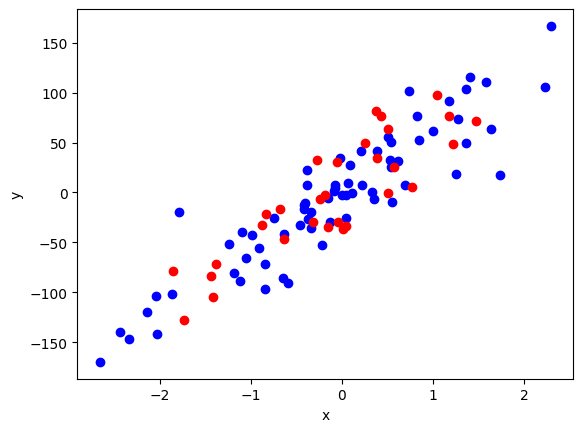

In [15]:
demo_dataset = np.loadtxt("demodataset.csv", delimiter=",")
#seed = random.randint(0, sys.maxsize)
seed = 1781569127924730678

X, y = split_features_target(demo_dataset)
# X = add_ones_left(X)
X_train, y_train, X_test, y_test = split_dataset_rng(X, y, 0.7, seed)

training_dataset = np.column_stack((X_train, y_train))
testing_dataset = np.column_stack((X_test, y_test))

plot_single_data(X_train, y_train, X_test, y_test)

---
3. a) Implement a linear (in the parameters) basis function regression model using the Gradient descent model with regularization, with a new $ \textbf{Classifier} $ subclass named $\textbf{GradDescReg}$.


In [16]:
class Classifier (Predictor):
    '''
    Implements a classifier model
    '''
    
    def __init__(self) -> None:
        super().__init__()

In [17]:
class GradDescReg (RegularizedModel, Classifier): # Diamond pattern, is fine because of MRO.
    '''
    Implements Gradient Descent with regularization
    '''

    # constructor
    def __init__(self, max_iters: int = 1000, min_conv_diff: float = 10**-8, learning_rate: float = 0.001, reg_lambda_: float = 0.0) -> None:
        self._max_iters = max_iters
        self._min_conv_diff = min_conv_diff
        self._alpha = learning_rate
        super().__init__(reg_lambda=reg_lambda_)


    # applies gradient descent with regularization
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X_full = super()._addOnesLeft(X)

        # initialize weights
        self._theta = np.zeros(X_full.shape[1]).reshape(-1, 1)

        # setup learning rate
        lr = self._alpha / X_full.shape[0]
        
        # setup regularization
        reg = 1 - self._lambda * lr

        # setup residuals
        h = self.predict(X)
        r = h - y
        
        epoch = 0
        conv_diff = self._min_conv_diff + 1
        while (epoch < self._max_iters and conv_diff > self._min_conv_diff):
            # apply gradient descent with regularization (1 epoch)
            new_theta = (reg * self._theta) - (lr * (X_full.T @ r))

            # checks the norm of the difference in thetas and updates theta
            conv_diff = np.linalg.norm(new_theta - self._theta)
            self._theta = new_theta
            
            epoch += 1

---
3. b) Using $\textbf{GradDescReg}$ class, fit the regression model to the training set and predict with
the test dataset, for values of the regularization term λ = [0, 200], with resolution 1.
Plot the mean square error (mse) for the test dataset for all values of λ.
What is the λ that minimizes the mse?

lambda that minimizes mse for current training set: 33.0


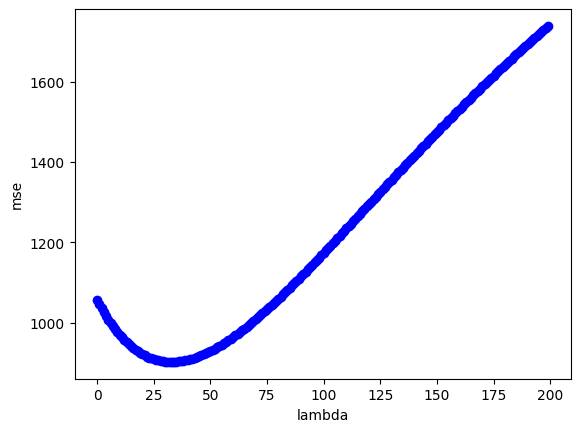

In [18]:
#Solve
grad_desc_reg = GradDescReg(1000, 10**-8, 0.001, 0.1)
best_lambda, all_mse = grad_desc_reg.find_optimal_lambda(X_train, y_train, X_test, y_test, [0, 200], 1.0)
#grad_desc_reg.fit(X, y)
#print(neq.theta())

print(f"lambda that minimizes mse for current training set: {best_lambda}")
#print(all_mse)
plt.scatter(all_mse[0], all_mse[1], color = "blue")
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()
#plotSingleRegression(X, y, xp1, yp1)

---
3. c) Plot the train dataset, test datasets, and the regression for the λ that minimizes the mse
obtained in b).

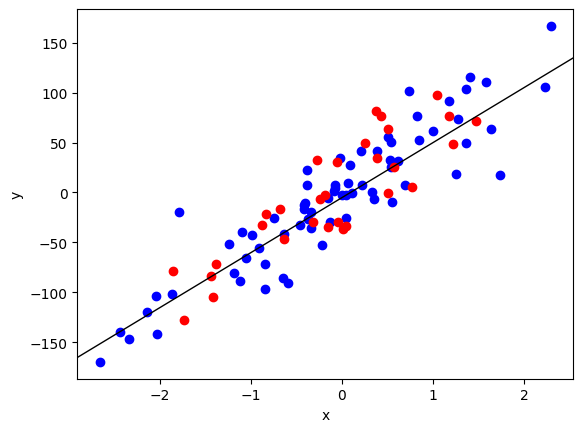

In [19]:
grad_desc_reg.set_lambda(best_lambda)
grad_desc_reg.fit(X_train, y_train)

thetas = grad_desc_reg.theta()
intercept = thetas[0][0]
slope = thetas[1][0]

plt.scatter(X_train, y_train, color = "blue")
plt.scatter(X_test, y_test, color = "red")
plt.axline((0, intercept), slope=slope, color="black", linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

---
3. d) Repeat b) with the $\textbf{NormalEQReg}$ class.

In [20]:
print(seed)

1781569127924730678


lambda that minimizes mse for current training set: 0


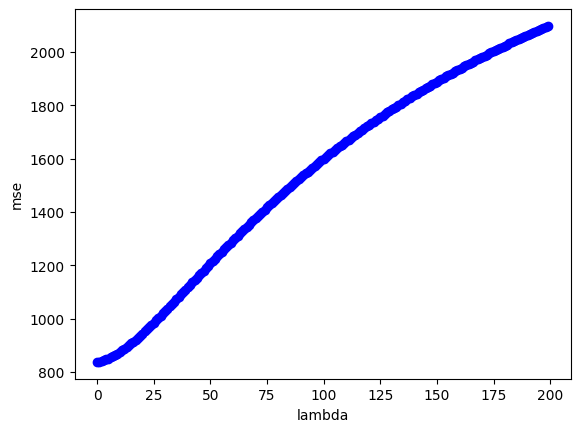

In [21]:
normal_eq_reg = NormalEQReg(0.0)
normal_eq_best_lambda, normal_eq_all_mse = normal_eq_reg.find_optimal_lambda(X_train, y_train, X_test, y_test, [0, 200], 1.0)

print(f"lambda that minimizes mse for current training set: {normal_eq_best_lambda}")
plt.scatter(normal_eq_all_mse[0], normal_eq_all_mse[1], color = "blue")
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

---
3. e) Compare the results in c) and d)

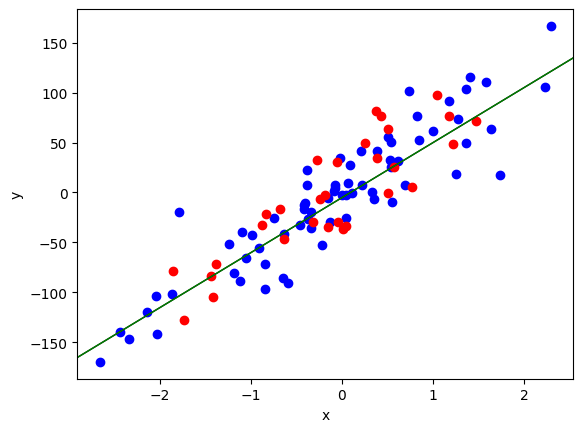

In [24]:
normal_eq_thetas = grad_desc_reg.theta()
normal_eq_intercept = thetas[0][0]
normal_eq_slope = thetas[1][0]

plt.scatter(X_train, y_train, color = "blue")
plt.scatter(X_test, y_test, color = "red")
plt.axline((0, intercept), slope=slope, color="black", linewidth=1)
plt.axline((0, normal_eq_intercept), slope=normal_eq_slope, color="green", linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As can be seen in the graph above, both Gradient Descent and the Normal Equation reach the exact same line for their optimal lambda.
We notice by comparing the graphs from d) and from b) that although for the Gradient Descent benefits from a regularization hyperparameter (lambda) of ~33, the Normal Equation benefits from a lambda of 0.
Furthermore, it can be noted that for different seeds and therefore divisions of the dataset, the optimal lambda for the Gradient Descent fluctuates quite a bit, while the lambda for the Normal Equation sits at 0 every time. This suggests that the data available is enough for an accurate regression and isn't overfitting.

---
3. e) Propose a dataset {(x1(i),x2(i), y(i)) | i=1,…, 4} where x1 and x2 are independent binary variables
and y is a linearly separable dependent binary variable. Apply logistic regression and compute the
estimated probability of y = 1 when x1 = x2 = 0.5.